# Load a trained model and assess performance

In [81]:
import sys
import os
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')


In [109]:
# Directory in which the code sits
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'vae-sld')

#config_file = os.path.join(git_dir, 'scripts', 'config-a_si-air.json')
config_file = os.path.join(git_dir, 'scripts', 'config-cell-b.json')
#config_file = os.path.join(git_dir, 'scripts', 'config-erik.json')
with open(config_file, 'r') as fd:
    config = json.load(fd)

data_dir = config['data_dir']
train_dir = config['train_dir']
model_name = config['name']

# Add source to path
sys.path.append(config['src_dir'])
sys.path.append(os.path.join(config['src_dir'], 'src'))

import reflectivity_model
import network
import importlib
importlib.reload(reflectivity_model)
importlib.reload(network)

<module 'network' from '/Users/m2d/git/vae-sld/src/network.py'>

dict_keys(['loss', 'val_loss'])
Number of epochs: 55


<IPython.core.display.Javascript object>


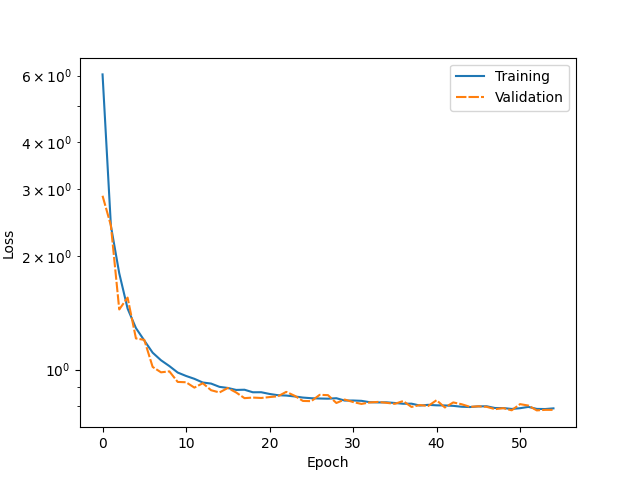

In [110]:
with open(os.path.join(train_dir, "%s_history.json" % model_name), 'r') as fd:
    history = json.load(fd)
    print(history.keys())
    
print("Number of epochs: %g" % len(history['loss']))

linestyle = (0, (5, 1))

fig = plt.figure(dpi=100)
plt.plot(np.arange(len(history['loss'])), history['loss'], label='Training')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='Validation', linestyle=linestyle)

if 'kl_metric' in history:
    plt.plot(np.arange(len(history['kl_metric'])), history['kl_metric'], label='KL training')
    plt.plot(np.arange(len(history['val_kl_metric'])), history['val_kl_metric'], label='KL validation', linestyle=linestyle)

    plt.plot(np.arange(len(history['nll_metric'])), history['nll_metric'], label='NLL training')
    plt.plot(np.arange(len(history['val_nll_metric'])), history['val_nll_metric'], label='NLL validation', linestyle=linestyle)

    plt.plot(np.arange(len(history['reconstruction_mse_metric'])), history['reconstruction_mse_metric'], label='R training')
    plt.plot(np.arange(len(history['val_reconstruction_mse_metric'])), history['val_reconstruction_mse_metric'], label='R validation', linestyle=linestyle)

plt.gca().legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [111]:
importlib.reload(reflectivity_model)
importlib.reload(network)

# Load the trained model
model = network.load_model(model_name, train_dir)

# We may use a different config to generate a validation set
with open(config_file, 'r') as fd:
    config_val = json.load(fd)

m = reflectivity_model.ReflectivityModels.from_dict(config_val)
q, test_data, test_pars = m.load(config_val['train_dir'])


# The prediction is the amplitude as [z_mean, z_log_var, z_sampled]
# We must split in three
preds = model.predict(test_data[:100])
print("Predicted SLD: %s" % str(preds.shape))

sld_pred, log_var_pred, sampled = tf.split(preds, 3, axis=1)

d_sld = tf.exp(log_var_pred)
i_test = 1

Dimensions: 150 400
4/4 [==============================] - 0s 15ms/step
Predicted SLD: (100, 600)


2023-05-22 16:13:43.842827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Get the training data in R(Q) and retrieve the error

Item: 5


<IPython.core.display.Javascript object>


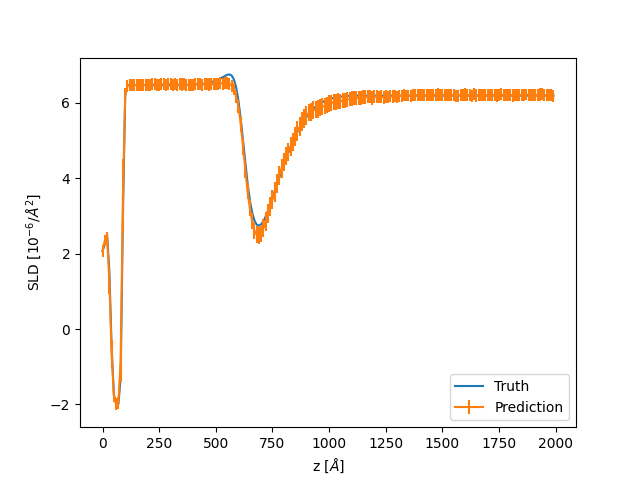

<IPython.core.display.Javascript object>


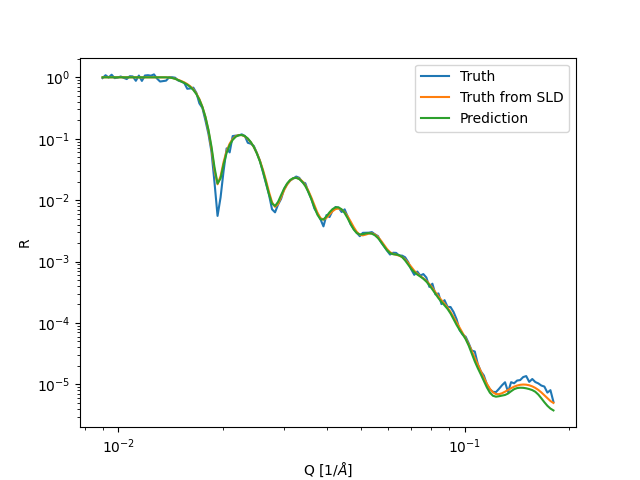

In [115]:
importlib.reload(reflectivity_model)

i_test +=1

print("Item: %s" % i_test)
#z = np.arange(config_val['z_left'], config_val['z_right']+config_val['dz'], config_val['dz'])
z = np.arange(0, config_val['dz']*len(test_pars[i_test]), config_val['dz'])

#for i in range(20):
#    print("%s %s" % (sld_pred[i_test][i], d_sld[i_test][i]))

fig = plt.figure(dpi=100)
plt.plot(z, test_pars[i_test], label="Truth")
plt.errorbar(z, sld_pred[i_test], yerr=d_sld[i_test], label="Prediction")
#plt.errorbar(z, sampled[i_test], yerr=d_sld[i_test], label="Sampled")
plt.gca().legend()
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD [$10^{-6}/\AA^2$]')
plt.show()

r_true_sld = reflectivity_model.calculate_reflectivity_from_profile(q, z, test_pars[i_test])
r_true = np.power(10, test_data[i_test])*q[0]**2/q**2
r_pred = reflectivity_model.calculate_reflectivity_from_profile(q, z, sld_pred[i_test])
r_pred_sampled = reflectivity_model.calculate_reflectivity_from_profile(q, z, sampled[i_test])

fig = plt.figure(dpi=100)
plt.plot(q, r_true, label="Truth")
plt.plot(q, r_true_sld, label="Truth from SLD")
plt.plot(q, r_pred, label="Prediction")
#plt.plot(q, r_pred_sampled, label="Sampled")
#plt.errorbar(z, sld_pred[i_test], yerr=d_sld[i_test], label="Prediction")
#plt.errorbar(z, sampled[i_test], yerr=d_sld[i_test], label="Sampled")
plt.gca().legend()
plt.xlabel('Q [$1/\AA$]')
plt.ylabel('R')
plt.xscale('log')
plt.yscale('log')
plt.show()



Variance: 8.072659977315803 percent
1/1 [==============================] - 0s 12ms/step


<IPython.core.display.Javascript object>


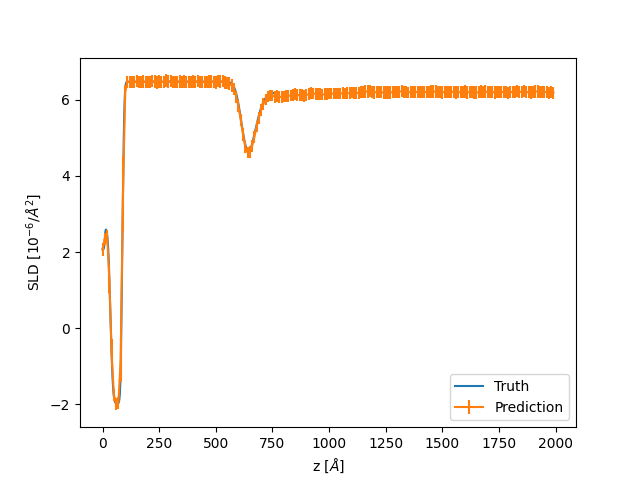

<IPython.core.display.Javascript object>


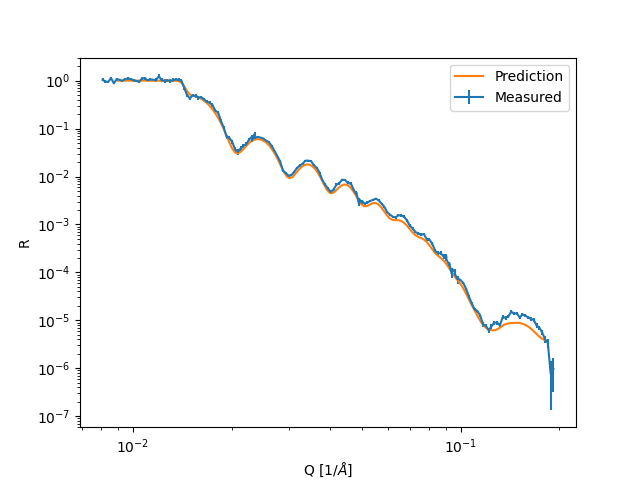

In [120]:
sld_fit = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/201282-profile.dat")).T
d = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/REFL_201282_reduced_data.txt")).T
scale = 1.

#sld_fit = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/201298-profile.dat")).T
#d = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/REFL_201298_reduced_data.txt")).T

#sld_fit = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/201306-profile.dat")).T
#d = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/REFL_201306_reduced_data.txt")).T

#sld_fit = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/201290-profile.dat")).T
#d = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/REFL_201290_reduced_data.txt")).T


var = np.average(d[2]/d[1]*100)

print("Variance: %s percent" % var)
meas = scale * np.interp(q, d[0], d[1])
d_meas = scale * np.interp(q, d[0], d[2])
meas = np.log10(meas*q**2/q[0]**2)
preds = model.predict(np.asarray([meas]))
sld_pred, log_var_pred, sampled = tf.split(preds, 3, axis=1)
d_sld = tf.exp(log_var_pred)

acc = []

for i in range(100):

    _meas = meas * (1 + d_meas*tf.keras.backend.random_normal(shape=tf.shape(meas)))

    preds = model.predict(np.asarray([_meas]), verbose=0)
    _sld_pred, _, _ = tf.split(preds, 3, axis=1)
    acc.append(_sld_pred)
    
acc = np.asarray(acc)
sld_pred = np.median(acc, axis=0)
sld_std = np.std(acc, axis=0)
d_sld += sld_std

fig = plt.figure(dpi=100)
plt.plot(sld_fit[0][-1]-sld_fit[0], sld_fit[1], label="Truth")
plt.errorbar(z, sld_pred[0], yerr=d_sld[0], label="Prediction")
#plt.errorbar(z, sampled[i_test], yerr=d_sld[i_test], label="Sampled")

plt.gca().legend()
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD [$10^{-6}/\AA^2$]')
plt.show()

r_pred = reflectivity_model.calculate_reflectivity_from_profile(q, z, sld_pred[0])
#r_pred = np.log(r_pred * q**2 / q[0]**2)

fig = plt.figure(dpi=100)
#plt.plot(q, meas, label="Measured")
plt.errorbar(d[0], scale * d[1], yerr=scale*d[2], label="Measured")

#r_pred = r_pred * (1 + 0.05*tf.keras.backend.random_normal(shape=tf.shape(r_pred)))


plt.plot(q, r_pred, label="Prediction")

plt.gca().legend()
plt.xlabel('Q [$1/\AA$]')
plt.ylabel('R')
plt.xscale('log')
plt.yscale('log')
plt.show()

